In [1]:
#### Load the necessary modules###
import pandas as pd
import numpy as np
import pickle
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', rc={'axes.grid': False})
from itertools import cycle
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
from scipy.stats import norm,t
from tqdm import tqdm
from sklearn.utils import resample
from sklearn.datasets import make_classification
from collections import Counter
from matplotlib import pyplot
from numpy import where
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone
from scipy import interp

In [2]:
#Read in ML input 
    #samples as rows with last column as cohort for classification
    #columns as features (i.e. GSVA scores or log2 expression values)
df = pd.read_csv('/Users/hmoye/Desktop/sepsis-main-2/BPD5-31_25.csv')
#Set up ML variables: x is df with feature values; y is cohort for classification
X1 = df.drop(['sepsis'],axis=1)
y1 = df.sepsis
X1 = StandardScaler().fit_transform(X1)
data = pd.DataFrame(X1)
data.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,99%,max
0,284.0,1.250956e-17,1.001765,-0.738073,-0.738073,-0.699270,-0.660467,-0.544059,-0.350045,0.270800,0.891645,4.413388,9.350657
1,284.0,5.003822e-17,1.001765,-2.385498,-2.385498,-1.368767,-1.368767,-0.690947,-0.013127,0.664693,1.342514,2.077949,3.714884
2,284.0,2.501911e-17,1.001765,-0.282574,-0.282574,-0.282574,-0.282574,-0.282574,-0.282574,-0.282574,-0.282574,3.538899,3.538899
3,284.0,-7.505733e-17,1.001765,-0.310685,-0.310685,-0.310685,-0.310685,-0.310685,-0.310685,-0.310685,-0.310685,3.218695,3.218695


In [3]:
from sklearn.datasets import make_classification
from collections import Counter
from matplotlib import pyplot
from numpy import where
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
#Random oversample with SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X1, y1)

In [4]:
# 初始化设置
shap.initjs()
plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [5]:
# 配置参数
plt.style.use('seaborn-v0_8')
seed = 1
models = [
    ('LR', LogisticRegression(random_state=seed)),
    ('RF', RandomForestClassifier(random_state=seed)),
    ("SVM", svm.SVC(probability=True,random_state=seed)),
    ('DTREE', DecisionTreeClassifier(random_state=seed)),
    ('ADB', AdaBoostClassifier(random_state=seed)),
    ('NB', GaussianNB()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    ('GB', GradientBoostingClassifier(random_state=seed)),
    ('MLP', MLPClassifier())
]
n_bootstraps = 1000

In [6]:
def bootstrap_evaluation():
    results = []
    roc_data = {}
    mean_fpr = np.linspace(0, 1, 100)
    for name, model in tqdm(models, desc='Models'):
        auc_scores, f1_scores = [], []
        sensitivities, specificities = [], []
        tprs = []
        for _ in tqdm(range(n_bootstraps), desc=name, leave=False):
            # Bootstrap抽样
            idx = resample(np.arange(len(y)), stratify=y, replace=True)
            X_boot, y_boot = X[idx], y[idx]
            
            # 训练模型
            model.fit(X_boot, y_boot)
            
            # 预测完整数据集
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X)[:, 1]
            else:
                y_proba = model.decision_function(X)
            y_pred = (y_proba > 0.5).astype(int)
            
            # 计算指标
            auc = roc_auc_score(y, y_proba)
            auc_scores.append(roc_auc_score(y, y_proba))
            f1_scores.append(f1_score(y, y_pred))
            
            # 计算混淆矩阵
            tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
            sensitivities.append(tp / (tp + fn))
            specificities.append(tn / (tn + fp))
            # 新增：计算ROC曲线的fpr和tpr
            fpr, tpr, _ = roc_curve(y, y_proba)
            # 插值到mean_fpr网格上
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0  # 初始点设置为0
            tprs.append(interp_tpr)
        
        # 计算统计量
        def bootstrap_stats(values):
            mean = np.mean(values)
            std = np.std(values)
            ci = np.percentile(values, [2.5, 97.5])
            return mean, std, ci
        
        auc_mean, auc_std, auc_ci = bootstrap_stats(auc_scores)
        f1_mean, f1_std, f1_ci = bootstrap_stats(f1_scores)
        sens_mean, sens_std, _ = bootstrap_stats(sensitivities)
        spec_mean, spec_std, _ = bootstrap_stats(specificities)    
        # 存储结果
        results.append({
            'Model': name,
            'AUC Mean': auc_mean,
            'AUC CI': auc_ci,
            'F1 Mean': f1_mean,
            'F1 CI': f1_ci,
            'Sensitivity Mean': sens_mean,
            'Sensitivity Std': sens_std,
            'Specificity Mean': spec_mean,
            'Specificity Std': spec_std
        })
    
       # 新增：保存ROC曲线数据
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0  # 最后一个点设置为1
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + 1.96*std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - 1.96*std_tpr, 0)
    
        roc_data[name] = {
            'mean_fpr': mean_fpr,
            'mean_tpr': mean_tpr,
            'tprs_upper': tprs_upper,
            'tprs_lower': tprs_lower,
            'auc_mean': auc_mean,
            'auc_ci': auc_ci
        }

      # 新增：绘制所有模型的ROC曲线
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    for i,(name, data) in enumerate(roc_data.items()):
        current_color = colors[i]
        plt.plot(data['mean_fpr'], data['mean_tpr'], color = current_color,
                 label=f'{name} (AUC = {data["auc_mean"]:.2f} [{data["auc_ci"][0]:.2f}-{data["auc_ci"][1]:.2f}])',
                 lw=2, alpha=0.8)
        plt.fill_between(data['mean_fpr'], data['tprs_lower'], data['tprs_upper'],color = current_color,
                         alpha=0.2)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves of Multiple Models')
    plt.legend(loc='lower right')
    plt.savefig("output25.pdf", format="pdf", dpi=300, bbox_inches="tight")
    plt.show()
    return pd.DataFrame(results)


正在进行Bootstrap评估...


RF:  13%|████▋                               | 130/1000 [00:07<00:51, 16.97it/s]


RF:  32%|███████████▋                        | 324/1000 [00:18<00:40, 16.84it/s]


RF:  52%|██████████████████▋                 | 518/1000 [00:30<00:28, 17.05it/s]


RF:  71%|█████████████████████████▋          | 712/1000 [00:41<00:16, 17.14it/s]


RF:  91%|████████████████████████████████▌   | 906/1000 [00:52<00:05, 17.19it/s]


SVM:  38%|█████████████▍                     | 384/1000 [00:05<00:08, 71.07it/s]


DTREE:  75%|████████████████████████▏       | 754/1000 [00:01<00:00, 410.87it/s]


ADB:  36%|████████████▌                      | 360/1000 [00:10<00:18, 35.53it/s]


ADB:  75%|██████████████████████████▏        | 748/1000 [00:20<00:07, 35.52it/s]


LDA:  34%|███████████▋                      | 343/1000 [00:00<00:01, 427.64it/s]


GB:  21%|███████▋                            | 212/1000 [00:06<00:22, 34.34it/s]


GB:  60%|█████████████████████▌              | 600/1000 [00:17<00:11, 34.28it/s]


GB:  99%|███████████████████████████████████▌| 988/1000 [00:28<00:00, 34.29it/s]


MLP:   0%|                                             | 0/1000 [00:00<?, ?it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:   0%|                                     | 1/1000 [00:00<01:44,  9.57it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:   0%|                                     | 3/1000 [00:00<01:29, 11.16it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:   1%|▎                                    | 9/1000 [00:00<01:15, 13.18it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:   1%|▍                                   | 11/1000 [00:00<01:17, 12.76it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:   

MLP:   7%|██▋                                 | 73/1000 [00:06<01:26, 10.77it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:   8%|██▋                                 | 75/1000 [00:06<01:28, 10.46it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:   8%|██▊                                 | 77/1000 [00:07<01:24, 10.91it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:   8%|██▊                                 | 79/1000 [00:07<01:27, 10.53it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:   8%|██▉                                 | 81/1000 [00:07<01:23, 10.96it/s]Stochast

MLP:  15%|█████▎                             | 153/1000 [00:13<01:13, 11.60it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  16%|█████▍                             | 155/1000 [00:13<01:16, 11.08it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  16%|█████▍                             | 157/1000 [00:14<01:12, 11.63it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  16%|█████▋                             | 161/1000 [00:14<01:08, 12.17it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  16%|█████▋                             | 163/1000 [00:14<01:14, 11.31it/s]Stochast

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  24%|████████▎                          | 237/1000 [00:21<01:05, 11.57it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  24%|████████▎                          | 239/1000 [00:21<01:09, 10.98it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  24%|████████▍                          | 241/1000 [00:21<01:10, 10.82it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  24%|████████▌                          | 243/1000 [00:21<01:12, 10.51it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conve

MLP:  32%|██████████▌                      | 321/1000 [01:05<1:03:59,  5.65s/it]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  32%|███████████▎                       | 322/1000 [01:05<52:49,  4.67s/it]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  32%|███████████▎                       | 324/1000 [01:06<35:23,  3.14s/it]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  33%|███████████▍                       | 326/1000 [01:06<24:13,  2.16s/it]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  33%|███████████▌                       | 332/1000 [01:06<08:20,  1.33it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  3

MLP:  40%|█████████████▉                     | 398/1000 [01:12<00:57, 10.49it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  40%|██████████████                     | 400/1000 [01:12<00:58, 10.28it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  40%|██████████████                     | 402/1000 [01:12<00:59, 10.13it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  40%|██████████████▏                    | 404/1000 [01:13<00:55, 10.82it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  41%|██████████████▏                    | 406/1000 [01:13<00:56, 10.52it/s]Stochast

MLP:  47%|████████████████▎                  | 466/1000 [01:18<00:46, 11.50it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  47%|████████████████▍                  | 468/1000 [01:19<00:46, 11.49it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  47%|████████████████▍                  | 470/1000 [01:19<00:44, 11.96it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  47%|████████████████▌                  | 472/1000 [01:19<00:45, 11.69it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  47%|████████████████▌                  | 474/1000 [01:19<00:47, 11.11it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  48%|████████████████▋                  | 476/1000 [01:19<00:46, 11.26it/s]Stochastic Optimizer: Max

MLP:  55%|███████████████████                | 546/1000 [01:26<00:39, 11.42it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  55%|███████████████████▏               | 548/1000 [01:26<00:37, 11.91it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  55%|███████████████████▎               | 550/1000 [01:26<00:40, 11.23it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  55%|███████████████████▍               | 554/1000 [01:26<00:35, 12.42it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  56%|███████████████████▌               | 560/1000 [01:27<00:33, 13.07it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  5

MLP:  63%|█████████████████████▉             | 628/1000 [01:33<00:30, 12.31it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  63%|██████████████████████             | 630/1000 [01:33<00:30, 12.28it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  63%|██████████████████████             | 632/1000 [01:33<00:29, 12.31it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  63%|██████████████████████▏            | 634/1000 [01:33<00:30, 11.92it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  64%|██████████████████████▎            | 638/1000 [01:34<00:28, 12.52it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  6

MLP:  71%|████████████████████████▊          | 710/1000 [01:40<00:27, 10.65it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  71%|████████████████████████▉          | 712/1000 [01:40<00:27, 10.37it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  71%|████████████████████████▉          | 714/1000 [01:41<00:28, 10.20it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  72%|█████████████████████████          | 716/1000 [01:41<00:26, 10.59it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conver

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  79%|███████████████████████████▌       | 788/1000 [01:47<00:19, 10.98it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  79%|███████████████████████████▋       | 790/1000 [01:47<00:19, 10.56it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  79%|███████████████████████████▋       | 792/1000 [01:48<00:20, 10.31it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  79%|███████████████████████████▊       | 794/1000 [01:48<00:20, 

MLP:  87%|██████████████████████████████▎    | 866/1000 [01:54<00:11, 11.80it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  87%|██████████████████████████████▍    | 868/1000 [01:55<00:11, 11.11it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  87%|██████████████████████████████▍    | 870/1000 [01:55<00:11, 11.51it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  87%|██████████████████████████████▌    | 872/1000 [01:55<00:11, 10.93it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  88%|██████████████████████████████▋    | 876/1000 [01:55<00:11, 11.27it/s]Stochast

MLP:  94%|█████████████████████████████████  | 944/1000 [02:01<00:05, 10.71it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  95%|█████████████████████████████████  | 946/1000 [02:02<00:04, 11.03it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  95%|█████████████████████████████████▏ | 948/1000 [02:02<00:04, 10.63it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  95%|█████████████████████████████████▎ | 950/1000 [02:02<00:04, 10.36it/s]Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLP:  95%|█████████████████████████████████▎ | 952/1000 [02:02<00:04, 11.06it/s]Stochast

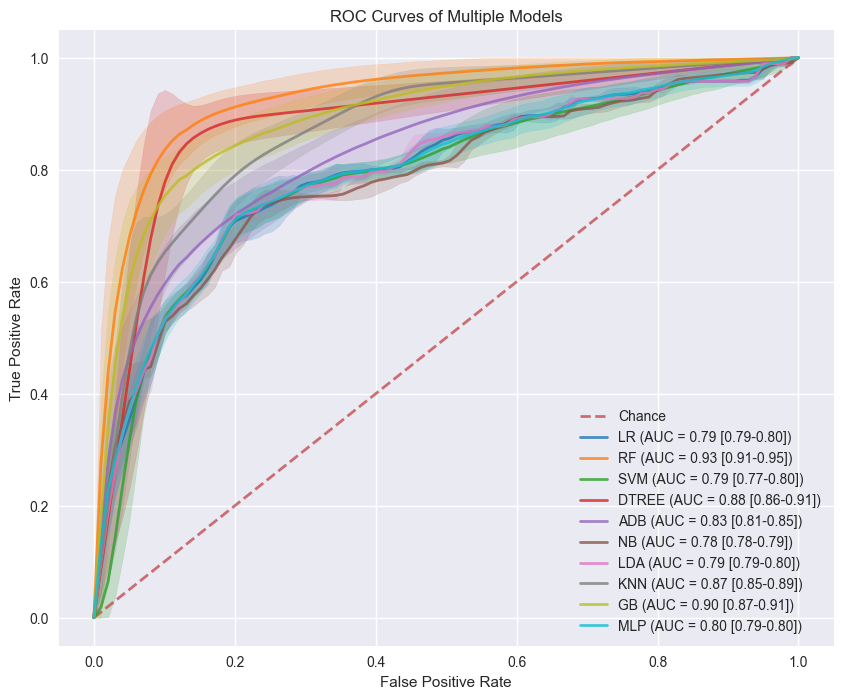


Bootstrap结果：
   Model  AUC Mean                                    AUC CI  F1 Mean  \
0     LR     0.795   [0.7892520775623268, 0.797534626038781]    0.704   
1     RF     0.929  [0.9083057479224377, 0.9477860110803323]    0.872   
2    SVM     0.788  [0.7734335180055402, 0.7980058864265928]    0.714   
3  DTREE     0.884   [0.855887811634349, 0.9115540166204986]    0.859   
4    ADB     0.834  [0.8089982686980609, 0.8541585872576178]    0.746   
5     NB     0.785  [0.7780986842105265, 0.7893081717451524]    0.614   
6    LDA     0.795  [0.7917728531855956, 0.7970637119113575]    0.701   
7    KNN     0.871  [0.8465363573407202, 0.8926738227146815]    0.801   
8     GB     0.895  [0.8735595567867036, 0.9139342105263158]    0.823   
9    MLP     0.797  [0.7874432132963989, 0.8025221606648199]    0.721   

                                      F1 CI  Sensitivity Mean  \
0   [0.6748447610345535, 0.745238295111993]             0.634   
1  [0.8446866485013623, 0.8947403887076181]         

In [7]:
print("\n正在进行Bootstrap评估...")
boot_results = bootstrap_evaluation()
print("\nBootstrap结果：")
print(boot_results.round(3))

In [8]:
boot_results.to_csv('bootstrap_results42.csv', index=False)

In [9]:
#Read in ML input 
    #samples as rows with last column as cohort for classification
    #columns as features (i.e. GSVA scores or log2 expression values)
df = pd.read_csv('/Users/hmoye/Desktop/sepsis-main-2/BPD5-31_25.csv')
#Set up ML variables: x is df with feature values; y is cohort for classification
X1 = df.drop(['sepsis'],axis=1)
y1 = df.sepsis
X1 = StandardScaler().fit_transform(X1)
data = pd.DataFrame(X1)
data.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,99%,max
0,284.0,1.250956e-17,1.001765,-0.738073,-0.738073,-0.699270,-0.660467,-0.544059,-0.350045,0.270800,0.891645,4.413388,9.350657
1,284.0,5.003822e-17,1.001765,-2.385498,-2.385498,-1.368767,-1.368767,-0.690947,-0.013127,0.664693,1.342514,2.077949,3.714884
2,284.0,2.501911e-17,1.001765,-0.282574,-0.282574,-0.282574,-0.282574,-0.282574,-0.282574,-0.282574,-0.282574,3.538899,3.538899
3,284.0,-7.505733e-17,1.001765,-0.310685,-0.310685,-0.310685,-0.310685,-0.310685,-0.310685,-0.310685,-0.310685,3.218695,3.218695


In [10]:
# 初始化设置
shap.initjs()
plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [11]:
#Random oversample with SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X1, y1)

In [12]:
# 训练随机森林分类器
model = RandomForestClassifier(random_state=1).fit(X,y)

In [13]:
# 创建SHAP解释器并计算SHAP值
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)  # 获取Explanation对象

In [14]:
shap_values

[array([[ 0.07158136,  0.01974789, -0.41477669, -0.09555256],
        [ 0.19757425,  0.13161108,  0.05412124, -0.10230657],
        [ 0.04594114,  0.13226892,  0.04639085, -0.01793424],
        ...,
        [-0.27794446, -0.17069464,  0.02544127, -0.0161355 ],
        [-0.02651435, -0.01276628, -0.46073549,  0.01101612],
        [-0.22856385, -0.24416548,  0.02051646,  0.01321287]]),
 array([[-0.07158136, -0.01974789,  0.41477669,  0.09555256],
        [-0.19757425, -0.13161108, -0.05412124,  0.10230657],
        [-0.04594114, -0.13226892, -0.04639085,  0.01793424],
        ...,
        [ 0.27794446,  0.17069464, -0.02544127,  0.0161355 ],
        [ 0.02651435,  0.01276628,  0.46073549, -0.01101612],
        [ 0.22856385,  0.24416548, -0.02051646, -0.01321287]])]

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


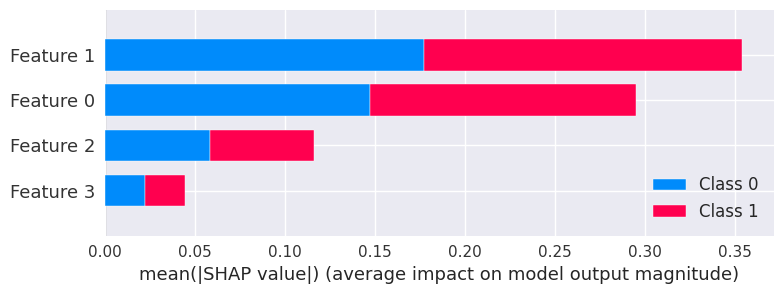

<Figure size 800x550 with 0 Axes>

In [15]:
shap.summary_plot(shap_values,X)
plt.savefig("shap_summary_plot.pdf",format="pdf")
plt.show()

In [16]:
feature_names= df.columns[0:4]

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

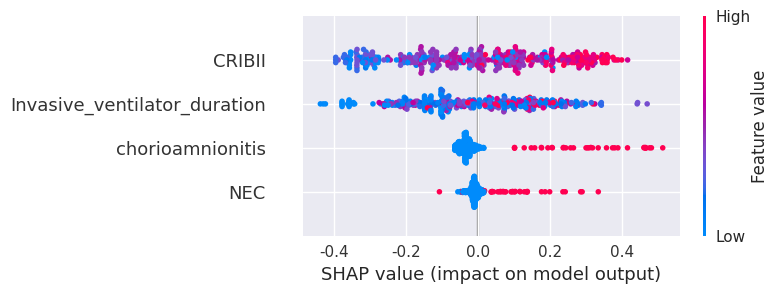

In [17]:
shap.summary_plot(shap_values[1],X.astype("float"), feature_names = feature_names,max_display=36,show=False)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

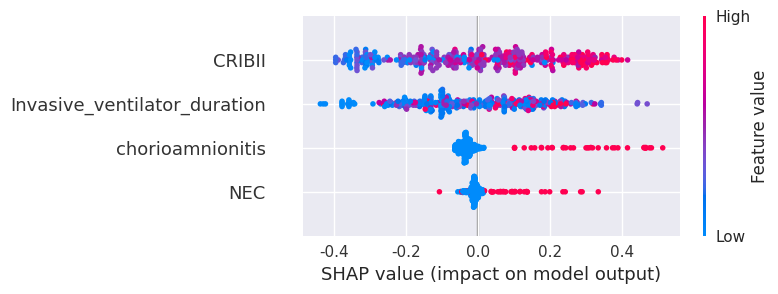

In [18]:
shap.summary_plot(shap_values[1], X.astype("float"), feature_names = feature_names,max_display=36,show=False)
plt.savefig('shap_rf.pdf')